<a href="https://colab.research.google.com/github/jessicaa-huang/spatial-vision/blob/main/graph_depth_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

# Variable Inputs/Files

In [13]:
# Variable Inputs
annotatedFileName = 'sword_panover_annotated.xml'
title = "Sword Pan Over Depth"

# path to depth npy files
depth_path = '/content/depth/0'
depth_fend = '_depth.npy'

# Position of Camera + sword
# Location 1 - Pommel
camPos1 = "sword_camera_position.txt"
objPos1 = "sword_panover_pommel.txt"

# Location 2 - Handle
camPos2 = "sword_camera_position.txt"
objPos2 = "sword_panover_handle.txt"

# Location 3 - Blade
camPos3 = "sword_camera_position.txt"
objPos3 = "sword_panup_blade.txt"

# Location 4 - Rock
camPos4 = "sword_camera_position.txt"
objPos4 = "sword_panup_rock.txt"

# Read in xml file from CVAT annotations

In [14]:
tree = ET.parse(annotatedFileName)
root = tree.getroot()

In [15]:
# List to store box coordinates
pommel_bbox = []
handle_bbox = []
blade_bbox = []
rock_bbox = []

# Iterate over each <image> element
for image in root.findall('image'):
    image_name = image.get('name')

    # Iterate over each <box> element within the <image>
    for box in image.findall('box'):
        label = box.get('label')
        xtl = int(float(box.get('xtl')))
        ytl = int(float(box.get('ytl')))
        xbr = int(float(box.get('xbr')))
        ybr = int(float(box.get('ybr')))

        # Append frame #, coordinates to corresponding bbox list
        if label == 'pommel':
          pommel_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'handle':
          handle_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'blade':
          blade_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])
        elif label == 'rock':
          rock_bbox.append([image_name[1:4], [xtl + 1, ytl + 1, xbr, ybr]])

# Print the extracted annotations
# annotations formatted as [Frame #, Object part, [xmin, ymin, xmax, ymax]]
print(pommel_bbox)
print(handle_bbox)
print(blade_bbox)
print(rock_bbox)

[['001', [538, 395, 543, 400]], ['005', [538, 390, 543, 395]], ['010', [537, 383, 544, 389]], ['015', [537, 377, 543, 382]], ['020', [537, 369, 544, 375]], ['025', [537, 363, 543, 369]], ['030', [536, 357, 543, 365]], ['035', [536, 352, 543, 359]], ['040', [536, 347, 544, 355]], ['045', [537, 345, 544, 352]], ['050', [536, 343, 544, 351]], ['055', [536, 343, 544, 351]], ['060', [537, 346, 543, 351]], ['065', [536, 351, 544, 357]], ['070', [537, 356, 543, 363]], ['075', [537, 364, 543, 371]], ['080', [537, 372, 544, 379]], ['085', [536, 381, 544, 389]], ['090', [537, 394, 543, 399]], ['095', [537, 403, 542, 409]], ['100', [537, 415, 543, 422]]]
[['001', [537, 440, 543, 455]], ['005', [536, 436, 544, 453]], ['010', [536, 432, 544, 450]], ['015', [536, 427, 544, 447]], ['020', [536, 422, 544, 443]], ['025', [536, 418, 544, 440]], ['030', [535, 415, 544, 438]], ['035', [535, 411, 545, 435]], ['040', [535, 409, 545, 433]], ['045', [535, 407, 545, 432]], ['050', [535, 407, 545, 433]], ['055'

In [16]:
def depth_median_mean(bbox):
  start_index = '001'
  # depth_path = '/content/depth/0'
  # depth_fend = '_depth.npy'
  size_bbox = len(bbox)

  # code to load the depth image
  dimg = np.load(depth_path + start_index + depth_fend)

  depth_mean = np.zeros((size_bbox,1))
  depth_median = np.zeros((size_bbox,1))

  for i in range(size_bbox):
      index = bbox[i][0]
      dimg = np.load(depth_path + index + depth_fend)

      i_coords = bbox[i][1]
      depth_patch = dimg[i_coords[0]:i_coords[2],i_coords[1]:i_coords[3]]
      # print(depth_patch)

      depth_mean[i] = np.mean(depth_patch)
      depth_median[i] = np.median(depth_patch)
  return (depth_mean, depth_median)

In [17]:
def normalizeData(data, frameRef):
  result = [x/data[frameRef] for x in data]
  return result

In [18]:
maxFrameCount = 20
(pommel_mean, pommel_median) = depth_median_mean(pommel_bbox)
(handle_mean, handle_median) = depth_median_mean(handle_bbox)
(blade_mean, blade_median) = depth_median_mean(blade_bbox)
(rock_mean, rock_median) = depth_median_mean(rock_bbox)

# using max value
norm_pommel = normalizeData(pommel_mean, 10)
norm_handle = normalizeData(handle_mean, 10)
norm_blade = normalizeData(blade_mean, 10)
norm_rock = normalizeData(rock_mean, 10)

In [20]:
# Code from https://stackoverflow.com/questions/51272288/how-to-calculate-the-vector-from-two-points-in-3d-with-python

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
   deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
   runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
   for coOrd in deltaVals:
       runningSquared += coOrd**2
   return runningSquared**(1/2)
def findVec(point1,point2,unitSphere = False):
  #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
  finalVector = [0 for coOrd in point1]
  for dimension, coOrd in enumerate(point1):
      #finding total differnce for that co-ordinate(x,y,z...)
      deltaCoOrd = point2[dimension]-coOrd
      #adding total difference
      finalVector[dimension] = deltaCoOrd
  if unitSphere:
      totalDist = multiDimenDist(point1,point2)
      unitVector =[]
      for dimen in finalVector:
          unitVector.append( dimen/totalDist)
      return unitVector
  else:
      return finalVector

# Find real distance between vector camera -> object per frame
def magnitude(vector):
  return math.sqrt(sum(pow(element, 2) for element in vector))

Read Camera and Object's Blender Coordinates

In [21]:
# grabs camera translation from txtfile and returns [x,y,z]
def makeCameraTranslation(txtfile):
  # read in file's content
  file = open(txtfile, "r")
  contentArr = []

  while True:
    content = file.readline()
    contentArr.append(content.split("#"))
    if not content:
      break

  # make Camera Translation matrix
  camTranslation = []

  # split 3 x,y,z values for translation & rotation
  for i in range(1, len(contentArr) - 1):
    camTranslation.append((contentArr[i][1].split(",")))

  for j in range(len(camTranslation)):
    for m in range(3):
      camTranslation[j][m] = float(camTranslation[j][m])

  return camTranslation

In [22]:
def blenderDist(camPos_file, objPos_file):
  camPosition = makeCameraTranslation(camPos_file)
  objPosition = makeCameraTranslation(objPos_file)

  blenderDist = []

  for i in range(len(camPosition)):
    blenderDist.append(magnitude(findVec(camPosition[i], objPosition[i])))
  norm_blender = normalizeData(blenderDist, 50)
  return norm_blender

dist1 = blenderDist(camPos1, objPos1)
dist2 = blenderDist(camPos2, objPos2)
dist3 = blenderDist(camPos3, objPos3)
dist4 = blenderDist(camPos4, objPos4)

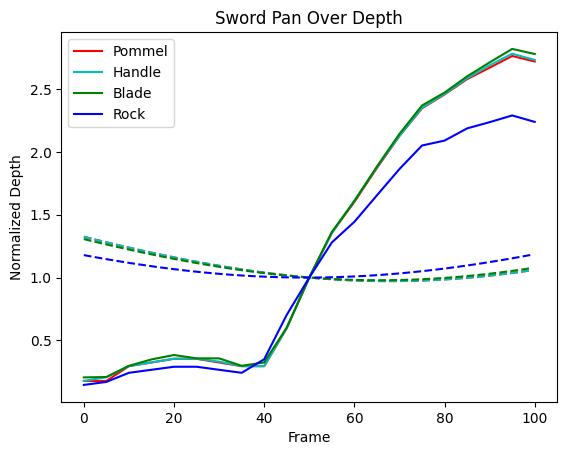

In [38]:
x = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

plt.title(title)
plt.xlabel('Frame')
plt.ylabel('Normalized Depth')

# Plot Depth Model's distances as solid lines
plt.plot(x[:len(norm_pommel)], norm_pommel, 'r', label='Pommel')
plt.plot(x[:len(norm_handle)], norm_handle, 'c', label='Handle')
plt.plot(x[:len(norm_blade)], norm_blade, 'g', label='Blade')
plt.plot(x[:len(norm_rock)], norm_rock, 'b', label='Rock')

# Plot Real Blender Distances as dashed lines
plt.plot(dist1, 'r', linestyle='--')
plt.plot(dist2, 'c', linestyle='--')
plt.plot(dist3, 'g', linestyle='--')
plt.plot(dist4, 'b', linestyle='--')

# Display legend
plt.legend()

plt.show()